# Bidirectional Neural Network Model - Hiperparameters Tuning

Input: testing different number of months in input using single PCA

Output: optimal max-shape portfolio with tight restrictions for the next period

## Data Pre-processing

In [1]:
import numpy as np

from keras.models import Sequential
from keras.layers import Dense, Flatten, GRU, Bidirectional, Input
from keras.regularizers import L2
from keras.optimizers import Adam

from sklearn.model_selection import StratifiedKFold
import keras_tuner

from helper_functions import train_and_evaluate_model, calculate_returns_for_model, daily_to_annual_returns

In [2]:
import os
os.chdir(os.path.expanduser('../data'))

from dotenv import load_dotenv
load_dotenv()

from DataProvider import DataProvider

In [3]:
data_provider = DataProvider()
y = data_provider.get_formatted_targets()

c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


## Cross validation to calculate optimal number of months

In [4]:
df_countries, _ = data_provider.get_etf_data()
days_to_recalculate = data_provider.get_days_to_recalculate()

val_split = int(0.7 * y.shape[0])
test_split = int(0.8 * y.shape[0])
dates_for_validation = days_to_recalculate[val_split:test_split]

df_prices_val = df_countries[dates_for_validation[0]:]
df_returns_val = np.log(df_prices_val).diff().fillna(0)

In [5]:
max_sharpe = 0
best_month_no = 0

for no_months in range(3, 10):
    print(f'Bidirectional Model for {no_months} months')
    x = data_provider.get_formatted_features(no_months=no_months)
    x_train, y_train, x_val, y_val, x_test, y_test = data_provider.train_train_split(
        x, y)

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    skf.get_n_splits(x_train, y_train)

    sum_sharpe = 0
    for _, (train_index, val_index) in enumerate(skf.split(x_train, np.zeros(y_train.shape[0]))):
        x_train_fold = x_train[train_index]
        y_train_fold = y_train[train_index]
        x_val_fold = x_train[val_index]
        y_val_fold = y_train[val_index]

        model = Sequential((
            Input(shape=x_train.shape[1:]),
            Bidirectional(layer=GRU(16, return_sequences=True),
                          backward_layer=GRU(16, activation='relu',
                             return_sequences=True,
                             go_backwards=True)),
            Flatten(),
            Dense(16, activation='relu', kernel_regularizer=L2(0.3)),
            Dense(y_train.shape[1], activation='softmax')
        ))
        model.compile(optimizer=Adam(learning_rate=1e-3),
                      loss='mean_squared_error')
        _ = model.fit(x_train_fold, y_train_fold,
                      validation_data=(x_val_fold, y_val_fold),
                      epochs=200, verbose=False)

        total_ret_val, _ = calculate_returns_for_model(
            model, x_val, dates_for_validation, df_returns_val)

        annual_returns = daily_to_annual_returns(total_ret_val)
        annual_volatility = total_ret_val.std()*np.sqrt(252)
        annual_sharpe_val = annual_returns/annual_volatility
        sum_sharpe += annual_sharpe_val
        print('Sharpe fold', annual_sharpe_val)

    mean_sharpe_val = sum_sharpe/5
    print('Mean Sharpe', mean_sharpe_val)
    if mean_sharpe_val > max_sharpe:
        max_sharpe = mean_sharpe_val
        best_month_no = no_months

print('Best number of months', best_month_no,
      'with mean Sharpe ratio', max_sharpe)

Bidirectional Model for 3 months
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
Sharpe fold 0.4082487982238115
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
Sharpe fold 0.3966729984505027
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
Sharpe fold 0.4067566394454112
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
Sharpe fold 0.4220996982336603
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
Sharpe fold 0.37240252006080704
Mean Sharpe 0.40123613088283855
Bidirectional Model for 4 months
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
Sharpe fold 0.3873316517827775
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
Sharpe fold 0.38101290595538
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
Sharpe fold 0.43813440620306965
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
Sharpe fold 0.37913698000968266
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step
Sharpe fold 0.37292724392807497
Mean Sharpe 0.391708637575797
Bidirectional Model for 5 months
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
Sharpe fold 0.3913330066047107
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
Sharpe fold 0.37610761003320

In [6]:
best_month_no = 9

x = data_provider.get_formatted_features(no_months=best_month_no)
x_train, y_train, x_val, y_val, x_test, y_test = data_provider.train_train_split(x, y)

## Hiperparameters Tuning

In [7]:
def build_model(hp):
    model = Sequential((
        Input(shape=x_train.shape[1:]),
        Bidirectional(layer=GRU(hp.Choice('gru_units', [16, 32, 64, 128, 256]), 
                                return_sequences=True),
                      backward_layer=GRU(hp.Choice('gru_units', [16, 32, 64, 128, 256]),
                                         activation='relu',
                                         return_sequences=True,
                                         go_backwards=True),
                      input_shape=x_train.shape[1:]),
        Flatten(),
        Dense(hp.Choice('dense_units', [32, 64, 128]),
              activation='relu', kernel_regularizer=L2(hp.Choice('regularizer', [0.1, 0.2, 0.3, 0.4]))),
        Dense(y_train.shape[1], activation='softmax')
    ))
    model.compile(loss='mse')
    return model

In [8]:
tuner = keras_tuner.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=100,
    directory='tuning',
    project_name='model_bidirectional')

c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\keras\src\layers\core\wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [9]:
tuner.search_space_summary()

Search space summary
Default search space size: 3
gru_units (Choice)
{'default': 16, 'conditions': [], 'values': [16, 32, 64, 128, 256], 'ordered': True}
dense_units (Choice)
{'default': 32, 'conditions': [], 'values': [32, 64, 128], 'ordered': True}
regularizer (Choice)
{'default': 0.1, 'conditions': [], 'values': [0.1, 0.2, 0.3, 0.4], 'ordered': True}


In [10]:
tuner.search(x_train, y_train, epochs=150, validation_data=(x_val, y_val))

Trial 59 Complete [00h 00m 12s]
val_loss: 0.0017010202864184976

Best val_loss So Far: 0.0005962718860246241
Total elapsed time: 00h 13m 38s


In [11]:
tuner.results_summary()

Results summary
Results in tuning\model_bidirectional
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 029 summary
Hyperparameters:
gru_units: 16
dense_units: 64
regularizer: 0.1
Score: 0.0005962718860246241

Trial 055 summary
Hyperparameters:
gru_units: 256
dense_units: 128
regularizer: 0.1
Score: 0.0005968974437564611

Trial 010 summary
Hyperparameters:
gru_units: 16
dense_units: 128
regularizer: 0.1
Score: 0.0006086834473535419

Trial 017 summary
Hyperparameters:
gru_units: 32
dense_units: 128
regularizer: 0.1
Score: 0.000613053678534925

Trial 009 summary
Hyperparameters:
gru_units: 64
dense_units: 64
regularizer: 0.2
Score: 0.0006181540084071457

Trial 036 summary
Hyperparameters:
gru_units: 64
dense_units: 128
regularizer: 0.1
Score: 0.0006190626882016659

Trial 041 summary
Hyperparameters:
gru_units: 128
dense_units: 128
regularizer: 0.1
Score: 0.0006311071338132024

Trial 005 summary
Hyperparameters:
gru_units: 32
dense_units: 64
regularizer: 0.1
Score:

## Best Model training

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_2 (Bidirectional) │ (None, 9, 32)          │         4,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 288)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 27)             │         1,755 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,571 (95.98 KB)

 Trainable params: 24,571 (95.98 KB)

 Non-trainable params: 0 (0.00 B)


Epoch 1/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 10.0881 - val_loss: 8.8943 - learning_rate: 0.0010
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.5416 - val_loss: 7.4901 - learning_rate: 0.0010
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.1821 - val_loss: 6.2692 - learning_rate: 0.0010
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6.0036 - val_loss: 5.2192 - learning_rate: 0.0010
Epoch 5/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.9922 - val_loss: 4.3243 - learning_rate: 0.0010
Epoch 6/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.1315 - val_loss: 3.5670 - learning_rate: 0.0010
Epoch 7/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.4043 - val_loss: 2.9298 - learning_rate: 0.0010
Epoch 8/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.7936 - val_loss: 2.3965 - learning_rate: 0.0010
Epoch 9/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.2828 - val_loss: 1.9518 - learning_rate: 0.0010
Epoch 10/200
7/7 ━━━━━━━━━━━━━━━━━

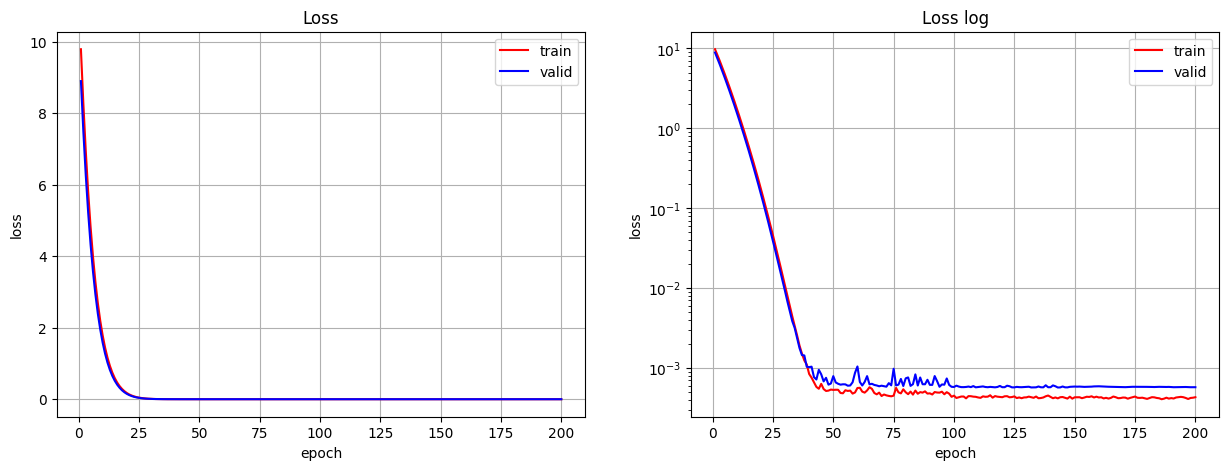

In [18]:
# best_model = tuner.get_best_models()[0]

best_model = Sequential((
    Input(shape=x_train.shape[1:]),
    Bidirectional(layer=GRU(16, return_sequences=True),
                    backward_layer=GRU(16, activation='relu',
                        return_sequences=True,
                        go_backwards=True)),
    Flatten(),
    Dense(64, activation='relu', kernel_regularizer=L2(0.1)),
    Dense(y_train.shape[1], activation='softmax')
))

train_and_evaluate_model(best_model, x_train, y_train,
                         x_val, y_val, x_test, y_test)

## Backtesting

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


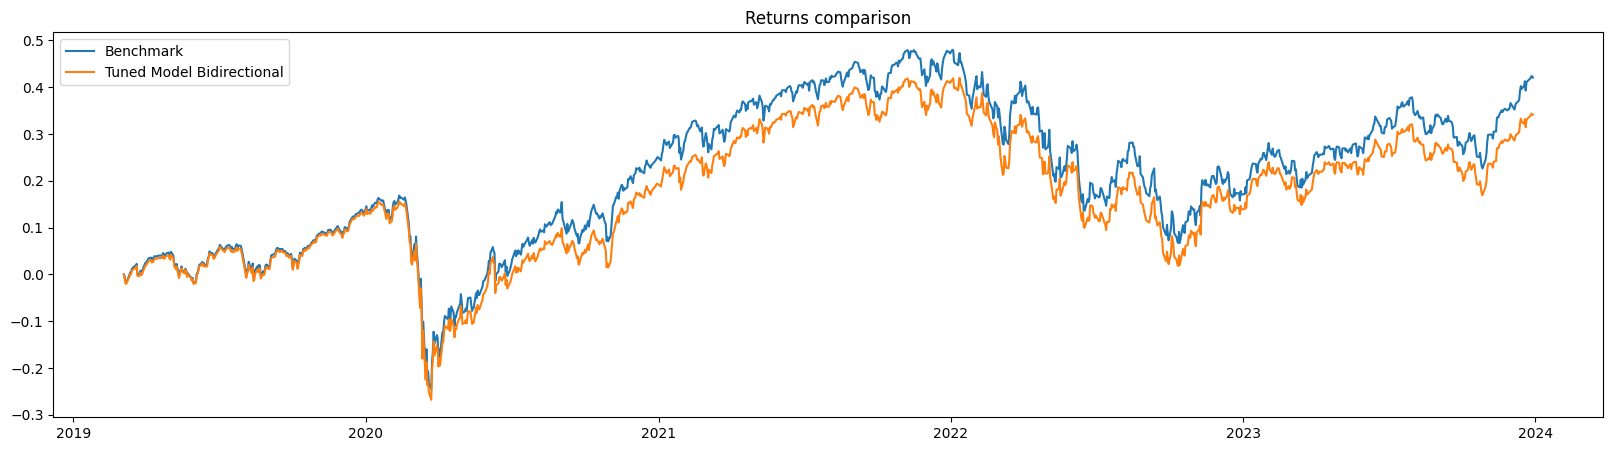

,Annual Returns,Annual Volatility,Sharpe Ratio,Sortino Ratio,Max Drawdown,Max Time Under Water,Calmar Ratio,Information Ratio
Benchmark,0.076754,0.203326,0.377494,0.442047,-0.354829,500.0,0.216313,0
Tuned Model Bidirectional,0.063517,0.201526,0.315181,0.365696,-0.366821,493.0,0.173156,-0.508893


In [19]:
from helper_functions import run_full_backtesting

models = {'Tuned Model Bidirectional': best_model}
df_results = run_full_backtesting(data_provider, x_test, models)
df_results